# Classification of AI Scientific Publications 
The Cora dataset consists of **2708 scientific publications classified into one of seven classes**.
The citation network consists of **5278 links.**
Each publication in the dataset is described by a 0 or 1 valued word vector indicating the absence or presence of the corresponding word from the dictionary. 
The dictionary consists of **1433 unique words.**


![title](https://tkipf.github.io/graph-convolutional-networks/images/gcn_web.png)

Source: https://tkipf.github.io/graph-convolutional-networks/

In [1]:
################################### Libraries ##################################################
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import  torch_geometric.data as data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures , AddSelfLoops
from torch_geometric.utils.convert import from_networkx
import os
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import *
#data_dir = "C:/Users/david/Desktop/cora"
data_dir = '/Users/davide_lupis/Desktop/cora'
import matplotlib.pyplot as plt
import seaborn as sns
#################################################################################################
def series(x,col=None):
    if col:
        return pd.Series(x[col].numpy())
    else:return pd.Series(x.numpy())

# Data Import

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["relation_type"] = "cites"
edgelist.sample(frac=1).head(5)

,target,source,relation_type
4681,248431,1113831,cites
2692,30817,3229,cites
2031,15429,89547,cites
4909,503877,1154076,cites
1667,10169,552469,cites


In [3]:
vocabulary = 1433
feature_names = ["w_{}".format(i) for i in range(vocabulary)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
node_data.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [4]:
node_data["subject"].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

In [5]:
# Converting string to values using label encoder since is not possible to switch from string to tensor
dictionary = { key:value for key,value in zip( node_data["subject"].unique(), np.arange(0,7))} 
node_data["subject"].map(dictionary).value_counts()

0    818
3    426
5    418
4    351
6    298
2    217
1    180
Name: subject, dtype: int64

In [6]:
balanced_train = pd.DataFrame()
for i in node_data["subject"].unique():
    balanced_train = pd.concat([balanced_train, node_data.loc[node_data["subject"]==i,:].sample(50) ] ,axis = "rows") 
balanced_train = balanced_train.sample(frac = 1)
balanced_train["subject"].map(dictionary).value_counts()

6    50
5    50
4    50
3    50
2    50
1    50
0    50
Name: subject, dtype: int64

In [7]:
#Creating a Balanced Mask for training
node_data['train_mask'] = node_data.index.to_series().apply(lambda x:True if x in balanced_train.index.tolist() else False)
node_data['test_mask'] = node_data.index.to_series().apply(lambda x:False if x in balanced_train.index.tolist() else True)

In [12]:
node_data.loc[node_data.train_mask== True,'subject'].value_counts()

Genetic_Algorithms        50
Rule_Learning             50
Neural_Networks           50
Case_Based                50
Probabilistic_Methods     50
Theory                    50
Reinforcement_Learning    50
Name: subject, dtype: int64

# Data Preprocessing

In [8]:
# Create the Graph
G = nx.from_pandas_edgelist(edgelist, edge_attr="relation_type")
print()
print(f'Dataset: {G}:')
# Create pytorch Data Object 
data_nx = from_networkx(G)
data_nx["x"] = torch.from_numpy(node_data[feature_names].values.astype(dtype=np.float32)) 
data_nx["y"] = torch.from_numpy(node_data["subject"].map(dictionary).values.astype(dtype=np.float32) ).type(torch.LongTensor)


# Make Balanced Mask as tensor
data_nx["train_mask"] = torch.from_numpy(node_data['train_mask'].values.flatten()).type(torch.BoolTensor)
data_nx["test_mask"] = torch.from_numpy(node_data['test_mask'].values.flatten()).type(torch.BoolTensor)


Dataset: Graph with 2708 nodes and 5278 edges:


# Goal: Node Classification
Predict the subject of a paper (node) on the basis of the surrounding node data and the structure of the graph

In [9]:
data = data_nx
num_classes = 7 
num_features = 1433
##################################### Model and Data Preparation ##########################################
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# How do we choose the dimension of the hidden layers ?
# There is no way of knowing in advance, the main idea is that we should reduce the dimensions  and iterate
# In literature they propose 16 as the best number of hidden layers
n_hidden_dim = 16
#################################################################################################

################################## MLP  ########################################################
# Use MLP model as model
model = MLP(hidden_channels=n_hidden_dim)
# Define loss criterion.

from sklearn.utils.class_weight import  compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes= np.unique(node_data["subject"].map(dictionary).unique()),
                                     y= series(data.y)
                                    )
#weights= torch.tensor(class_weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss()

# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
print(model)
def train():
      # Train option
      model.train()
      # Clear gradients.
      optimizer.zero_grad()
      # Perform a single forward pass for the iteration i
      out = model(data.x)
      # Compute the loss solely based on the training nodes.
      loss = criterion(out[data.train_mask == True ], data.y[data.train_mask == True])
      # Derive gradients.
      loss.backward()
      # Update parameters based on gradients.
      optimizer.step()
      return loss

def test():
      # Model is in evaluation mode
      model.eval()
      # Use model to make prediction
      out = model(data.x)
      # Use the class with highest probability since the output is a vector of softmax
      pred = out.argmax(dim=1)
      # Compute accuracy as the counter of  prediction vs ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions. to get Accuracy
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc, pred

for epoch in range(1, 201):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc_mlp,pred_mlp = test()
pred_mlp = series(pred_mlp,None)
print(f'Test Accuracy MLP: {test_acc_mlp:.4f}')
#################################################################################################


################################## Graph Convolution ############################################
# Use Graph Convolutional Layers
model = GCN(hidden_channels=n_hidden_dim)
print(model)
# Define Adam as optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
def train():
    # Training mode
    model.train()
    # Clear gradients.
    optimizer.zero_grad()
    # Perform a single forward pass for this iteration, note that edges are also an argument here
    out = model(data.x, data.edge_index)
    # Compute the loss solely based on the training nodes
    loss = criterion(out[data.train_mask],
                     data.y[data.train_mask])
    # Derive gradients.
    loss.backward()
    # Update parameters based on gradients.
    optimizer.step()
    return loss

def test():
    # Evaluation mode
    model.eval()
    # Compute predictions as output of model
    out = model(data.x, data.edge_index)
    # Use the class with highest probability since the output is a vector of softmax
    pred = out.argmax(dim=1)
    # Compute accuracy as the counter of  prediction vs ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # Derive ratio of correct predictions. to get Accuracy
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc,pred

for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc_gcn ,pred_gcn = test()
pred_gcn = series(pred_gcn,None)
print(f'Test Accuracy with GCN: {test_acc_gcn:.4f}')
#################################################################################################

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Test Accuracy MLP: 0.6408
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Test Accuracy with GCN: 0.2778


In [ ]:
y_pred  = pred_mlp[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
ax= figure.add_subplot()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues");
f1_score(y_true, y_pred,average="weighted").round(2)

In [ ]:
y_pred  = pred_gcn[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
ax= figure.add_subplot()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues");
f1_score(y_true, y_pred,average="weighted").round(2)

# TO DO :
    
   * Fix Balance 
   * Fix Test and Validation Mask because we dont get the same results as Planetoid 
   * Train mask in Planetoid is balancing the net that is why it performs better
   * Edges are not the same even of the Planetoid , thats why we perform differntly
   * Used Custom Balanced Mask to check if the results depends on balance data, we still have lower performance! 

In [13]:
############################################ Data Collection ###################################
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=None ) #NormalizeFeatures
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
#################################################################################################


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [14]:
series(data.y[data.train_mask]).value_counts()

6    20
5    20
4    20
3    20
2    20
1    20
0    20
dtype: int64

In [15]:
num_classes = 7 
num_features = 1433
##################################### Model and Data Preparation ##########################################
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# How do we choose the dimension of the hidden layers ?
# There is no way of knowing in advance, the main idea is that we should reduce the dimensions  and iterate
# In literature they propose 16 as the best number of hidden layers
n_hidden_dim = 16
#################################################################################################


################################## MLP  ########################################################
# Use MLP model as model
model = MLP(hidden_channels=n_hidden_dim)
# Define loss criterion.

from sklearn.utils.class_weight import  compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes= np.unique(node_data["subject"].map(dictionary).unique()),
                                     y= series(data.y)
                                    )
weights= torch.tensor(class_weights,dtype=torch.float)
#criterion  = torch.nn.NLLLoss(weight=weights) 
criterion = torch.nn.CrossEntropyLoss(weight=weights,reduction='mean')

# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
print(model)
def train():
      # Train option
      model.train()
      # Clear gradients.
      optimizer.zero_grad()
      # Perform a single forward pass for the iteration i
      out = model(data.x)
      # Compute the loss solely based on the training nodes.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      # Derive gradients.
      loss.backward()
      # Update parameters based on gradients.
      optimizer.step()
      return loss

def test():
      # Model is in evaluation mode
      model.eval()
      # Use model to make prediction
      out = model(data.x)
      # Use the class with highest probability since the output is a vector of softmax
      pred = out.argmax(dim=1)
      # Compute accuracy as the counter of  prediction vs ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions. to get Accuracy
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc, pred

for epoch in range(1, 201):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc_mlp,pred_mlp = test()
pred_mlp = series(pred_mlp,None)
print(f'Test Accuracy MLP: {test_acc_mlp:.4f}')
#################################################################################################


################################## Graph Convolution ############################################
# Use Graph Convolutional Layers
model = GCN(hidden_channels=n_hidden_dim)
print(model)
# Define Adam as optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
def train():
    # Training mode
    model.train()
    # Clear gradients.
    optimizer.zero_grad()
    # Perform a single forward pass for this iteration, note that edges are also an argument here
    out = model(data.x, data.edge_index)
    # Compute the loss solely based on the training nodes
    loss = criterion(out[data.train_mask],
                     data.y[data.train_mask])
    # Derive gradients.
    loss.backward()
    # Update parameters based on gradients.
    optimizer.step()
    return loss

def test():
    # Evaluation mode
    model.eval()
    # Compute predictions as output of model
    out = model(data.x, data.edge_index)
    # Use the class with highest probability since the output is a vector of softmax
    pred = out.argmax(dim=1)
    # Compute accuracy as the counter of  prediction vs ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # Derive ratio of correct predictions. to get Accuracy
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc,pred

for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc_gcn ,pred_gcn = test()
pred_gcn = series(pred_gcn,None)
print(f'Test Accuracy with GCN: {test_acc_gcn:.4f}')

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Test Accuracy MLP: 0.4990
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Test Accuracy with GCN: 0.7910


0.48

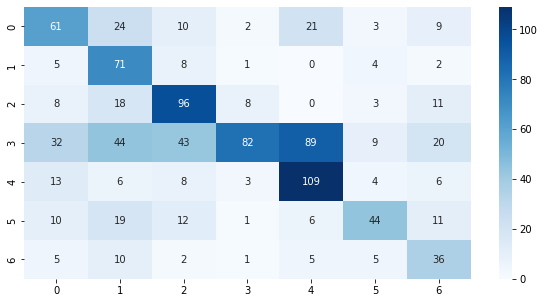

In [17]:
y_pred  = pred_mlp[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
ax= figure.add_subplot()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues");
f1_score(y_true, y_pred,average="weighted").round(2)

0.79

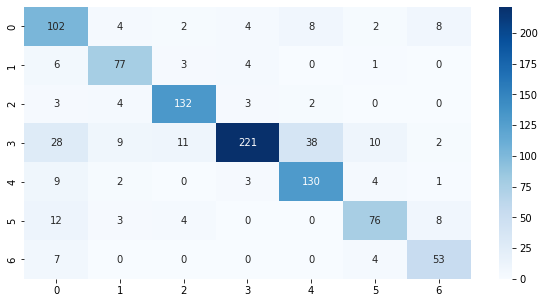

In [18]:
y_pred  = pred_gcn[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
ax= figure.add_subplot()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues");
f1_score(y_true, y_pred,average="weighted").round(2)

# References

* Semi-Supervised Classification with Graph Convolutional Networks: https://arxiv.org/abs/1609.02907

* Graph Convolutional Layers : https://tkipf.github.io/graph-convolutional-networks/

* Graph Datasets : https://linqs.soe.ucsc.edu/data

* Introdocution to Graph Neural Networks: https://towardsdatascience.com/a-gentle-introduction-to-graph-neural-network-basics-deepwalk-and-graphsage-db5d540d50b3

* PyTorch Geometric Documentation : https://pytorch-geometric.readthedocs.io/en/latest/index.html

In [ ]:
#pd.Series(series(data.train_mask),name='train_mask').to_csv('train_mask.csv',index = False)
#pd.Series(series(data.train_mask),name='test_mask').to_csv('test_mask.csv',index = False)

In [ ]:
!ls

In [ ]:
#train_mask = torch.from_numpy( pd.read_csv('train_mask.csv').values.flatten()  ).type(torch.BoolTensor)
#test_mask = torch.from_numpy(pd.read_csv('test_mask.csv').values.flatten()  ).type(torch.BoolTensor) 
## Split the data 
#train_ratio = 0.2
#num_nodes = data_nx.x.shape[0]
#num_train = int(num_nodes * train_ratio)
#idx = [i for i in range(num_nodes)]

## Creating the mask for training and test
#np.random.shuffle(idx)
#train_mask = torch.full_like(data_nx.y, False, dtype=bool)
#train_mask[idx[:num_train]] = True
#test_mask = torch.full_like(data_nx.y, False, dtype=bool)
#test_mask[idx[num_train:]] = True